In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rc
rc('text', usetex=False)

from skimage.transform import resize
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim

from polyphase.parallel import get_distance_matrix

from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph
from scipy.linalg import eigvalsh

In [3]:
# load the csv file with HTE data
df = pd.read_pickle('../data/ternary_hte.pkl')

In [4]:
def get_batch_of_phasediags(smstr, polymerstr):
    sys_df = df[(df['small molecule']==smstr) & (df['polymer']==polymerstr)]
    filename_list = []
    for _,row in sys_df.iterrows():
        fname = '../figures/hteplots/'+'_'.join(i for i in row.iloc[:3]) + '.png'
        filename_list.append(fname)
    
    return filename_list, sys_df

def get_ssim_distance(file0, file1):
    """ Given two image file names in file0, file1 compute distance"""
    
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    d = ssim(img0, img1, multichannel=True)
    
    return 1-d

In [7]:
solubs = pd.read_pickle('../expts/data/htpdata/solubility.pkl')
print('small molecules : ', solubs['small molecules'].name.values)
print('polymers: ', solubs['polymers'].name.values)

small molecules :  ['PC61BM' 'PC71BM' 'DPP(TBFu)2' 'F8-NODIPS' 'DPP(PhTT)2']
polymers:  ['MDMO-PPV' 'MEH-PPV' 'P3HT' 'PFO']


In [8]:
smstr = 'PC71BM'
polymerstr  = 'PFO'
files, sys_df = get_batch_of_phasediags(smstr, polymerstr)
print('Total of {} phase diagrams'.format(len(files)))

M = get_distance_matrix(files, get_ssim_distance) 

2020-08-26 11:50:57,235	INFO resource_spec.py:212 -- Starting Ray with 76.46 GiB memory available for workers and up to 36.78 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Total of 86 phase diagrams


2020-08-26 11:50:57,605	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-26 11:51:01,615	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


(pid=6623) Staging 0 on 10.106.16.7
(pid=6618) Staging 1 on 10.106.16.7
(pid=6627) Staging 2 on 10.106.16.7
(pid=6616) Staging 3 on 10.106.16.7
(pid=6626) Staging 4 on 10.106.16.7
(pid=6617) Staging 6 on 10.106.16.7
(pid=6615) Staging 15 on 10.106.16.7
(pid=6612) Staging 7 on 10.106.16.7
(pid=6619) Staging 10 on 10.106.16.7
(pid=6613) Staging 8 on 10.106.16.7
(pid=6622) Staging 12 on 10.106.16.7
(pid=6614) Staging 14 on 10.106.16.7
(pid=6624) Staging 5 on 10.106.16.7
(pid=6621) Staging 11 on 10.106.16.7
(pid=6625) Staging 9 on 10.106.16.7
(pid=6620) Staging 13 on 10.106.16.7
Processed : 14 took 00 Hr:09 min:16.78 sec 
(pid=6614) Staging 16 on 10.106.16.7
Processed : 15 took 00 Hr:09 min:17.06 sec 
(pid=6615) Staging 17 on 10.106.16.7
Processed : 13 took 00 Hr:09 min:21.65 sec 
(pid=6620) Staging 18 on 10.106.16.7
Processed : 12 took 00 Hr:09 min:33.92 sec 
(pid=6622) Staging 19 on 10.106.16.7
Processed : 11 took 00 Hr:09 min:34.46 sec 
(pid=6808) Staging 20 on 10.106.16.7
Processed : 1

In [9]:
# create the affinity matrix
delta = 1/len(files)
X = np.exp(- M ** 2 / (2. * delta ** 2))

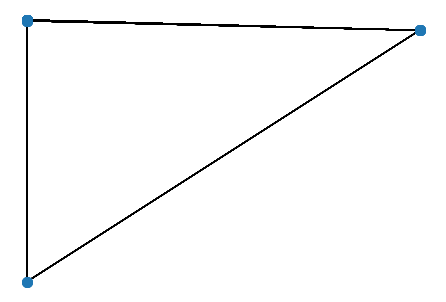

In [10]:
# using networkx spectral embedding
import networkx as nx
G = nx.from_numpy_matrix(X)
options = {"node_color": "C0", "node_size": 100}

nx.draw_spectral(G,**options)

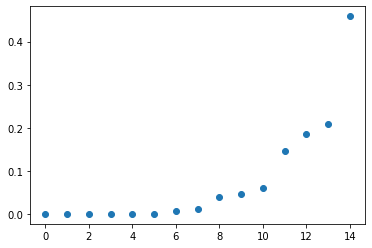

In [11]:
laplacian = csgraph.laplacian(X, normed=True)
eigen_values = eigvalsh(laplacian)

fig, ax = plt.subplots()
ax.scatter(np.arange(15),eigen_values[:15])
plt.show()

In [12]:
delta_sm = solubs['small molecules'].loc[solubs['small molecules'].name==smstr].iloc[:,2:5]
delta_polymer = solubs['polymers'].loc[solubs['polymers'].name==polymerstr].iloc[:,2:5]

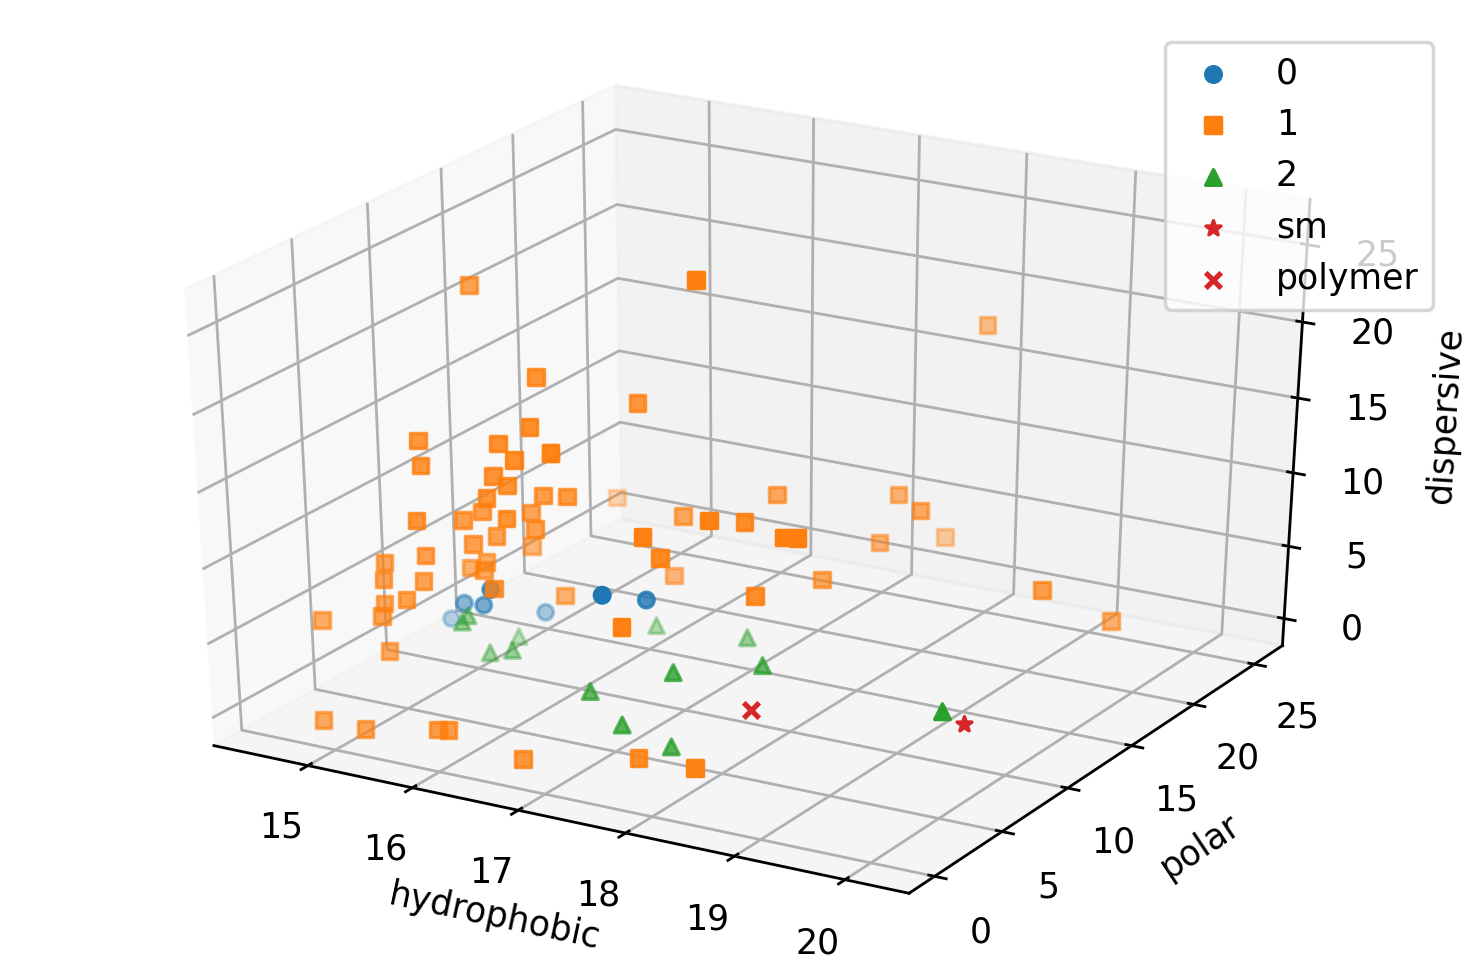

In [13]:
n_clusters = 3
clustering = SpectralClustering(n_clusters=n_clusters,assign_labels="discretize",random_state=0, affinity='precomputed')
labels = clustering.fit_predict(X)


markers = ['o','s','^','x']

fig = plt.figure(dpi=250)
ax = fig.add_subplot(projection='3d')
for m, label in zip(markers, range(n_clusters)):
    ax.scatter(sys_df.loc[labels==label,'solv_h'], sys_df.loc[labels==label,'solv_p'],
               sys_df.loc[labels==label,'solv_d'], marker=m, label=str(label))

ax.scatter(delta_sm['dispersive'],delta_sm['polar'],delta_sm['hydrogen'], 
           marker='*', color='tab:red', label='sm') 
ax.scatter(delta_polymer['dispersive'],delta_polymer['polar'],delta_polymer['hydrogen'],
           marker='x', color='tab:red', label='polymer')

ax.set_xlabel('hydrophobic')
ax.set_ylabel('polar')
ax.set_zlabel('dispersive')
ax.legend()
plt.tight_layout()
plt.show()

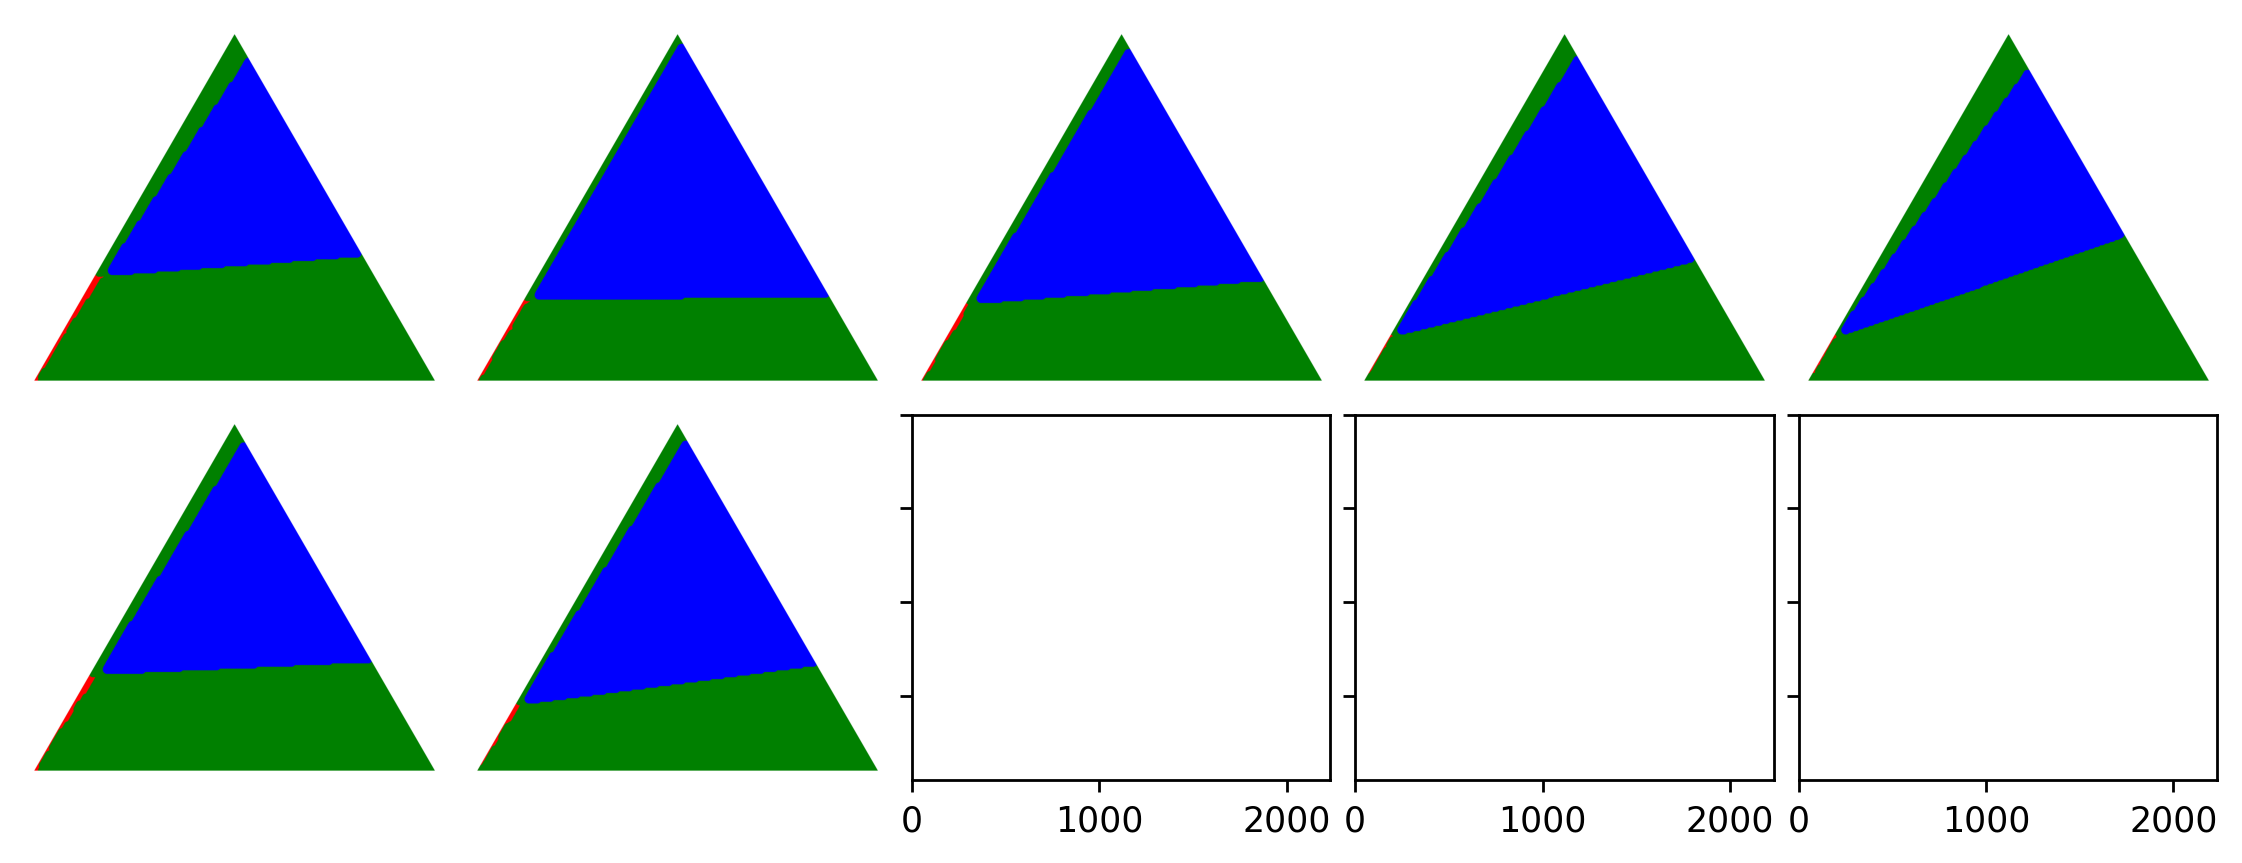

In [14]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_clustered_diagrams_grid(cluster_id):
    cluster_diags = sys_df.loc[labels==cluster_id,'solvent'].to_list()
    num_diags = len(cluster_diags)
    fig = plt.figure(figsize=(24, 4.), dpi=250)
    num_rows = int(np.floor(num_diags/5)+1)
    grid = ImageGrid(fig, 111,nrows_ncols=(num_rows, 5), axes_pad=(0.1,0.1))
    for ax, solvent in zip(grid, cluster_diags):
        fname = '../figures/hteplots/{}_{}_{}.png'.format(solvent,smstr,polymerstr)
        img = plt.imread(fname)
        ax.imshow(img)
        ax.axis('off')

    plt.axis('off')
    plt.show()
    
plot_clustered_diagrams_grid(0)

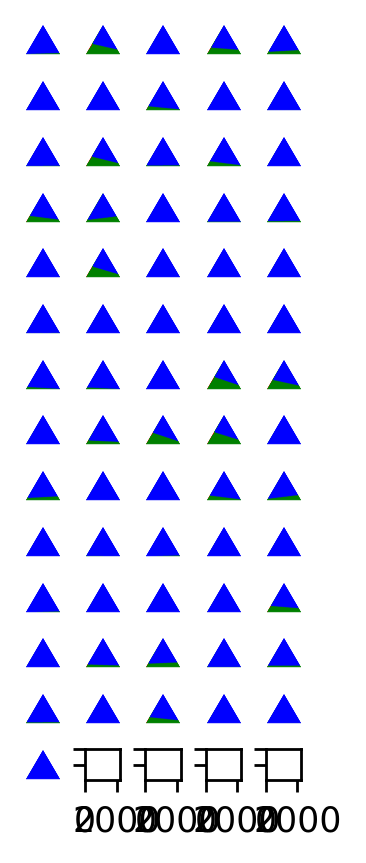

In [15]:
plot_clustered_diagrams_grid(1)

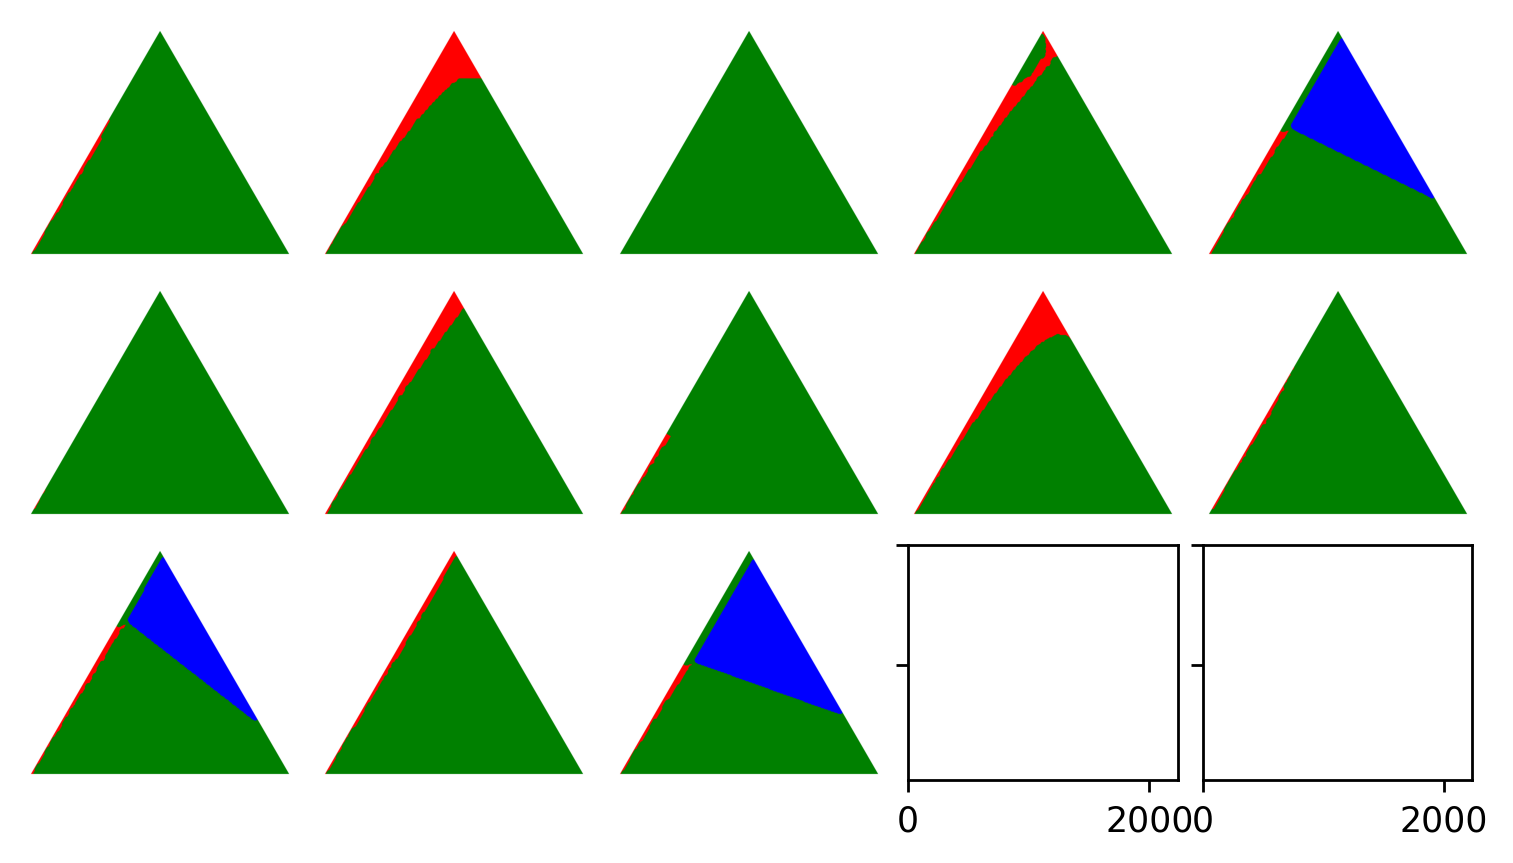

In [16]:
plot_clustered_diagrams_grid(2)